Fake News Detection using spark, pandas and dask

In [ ]:
!pip install pyspark
!pip install pandas

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing required libraries and creating a spark session

In [ ]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
spark=SparkSession.builder.master('local[2]').getOrCreate()
sc=spark.sparkContext
spark
spark.conf.set("spark.sql.execution.arrow.enabled", "true")



Importing the dataset from google drive



In [ ]:
train = pd.read_table('/content/gdrive/My Drive/train.tsv', names = ["id", "target_label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])
test=pd.read_table('/content/gdrive/My Drive/test.tsv', names = ["id", "target_label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])
valid=pd.read_table('/content/gdrive/My Drive/valid.tsv', names = ["id", "target_label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])

# converting problem to binary classification
y_label_dict = {"pants-fire" : "F", "false" : "F", "barely-true" : "F", "half-true" : "T", "mostly-true" : "T", "true" : "T"}

train = train.replace({"target_label": y_label_dict})
test = test.replace({"target_label": y_label_dict})
valid = valid.replace({"target_label": y_label_dict})

Creating a Tokenizing function for the datasets

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType

# function to tokenize text
def tokenize(sentenceDataFrame):

    tokenizer = Tokenizer(inputCol="statement", outputCol="words")

    regexTokenizer = RegexTokenizer(inputCol="statement", outputCol="words", pattern="\\W")
    # alternatively, pattern="\\w+", gaps(False)

    regexTokenized = regexTokenizer.transform(sentenceDataFrame)
    return regexTokenized

Converting the tables into spark dataframes

In [ ]:
# converting pandas DataFrame to Spark DataFrame
train = spark.createDataFrame(train)
test = spark.createDataFrame(test)
valid = spark.createDataFrame(valid)

train.show()

+----------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+-----------+-----+---------+-----------+----------+--------------------+
|        id|target_label|           statement|             subject|             speaker|                 job|            state|       party|barely-true|false|half-true|mostly-true|pants-fire|               venue|
+----------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+-----------+-----+---------+-----------+----------+--------------------+
| 2635.json|           F|Says the Annies L...|            abortion|        dwayne-bohac|State representative|            Texas|  republican|        0.0|  1.0|      0.0|        0.0|       0.0|            a mailer|
|10540.json|           T|When did the decl...|energy,history,jo...|      scott-surovell|      State delegate|         Virginia|    democrat|        

Data Cleaning and Pre-processing

In [ ]:
train = tokenize(train)

In [ ]:
from pyspark.ml.feature import StopWordsRemover

def remove_stopw(df):
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    df=remover.transform(df)
    return df

train=remove_stopw(train)

Implementing Ngram model

In [ ]:
# from pyspark.ml.feature import NGram

# def ngram(worddf):
#     ngram = NGram(n=2, inputCol="filtered", outputCol="ngrams")

#     ngramdf = ngram.transform(worddf)
#     ngramdf.select("ngrams").show(truncate=False)
#     return ngramdf

# ngram(df).show()

Implementing Count Vectorizer

In [ ]:
from pyspark.ml.feature import CountVectorizer

def count_vectorize(df):
    # fit a CountVectorizerModel from the corpus.
    cv = CountVectorizer(inputCol="filtered", outputCol="features", minDF=1.0)

    model = cv.fit(df)

    result = model.transform(df)
    return result, model

train, count_vectorizer = count_vectorize(train)

String Indexing

In [ ]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol = "target_label", outputCol = "label")
indexerFit = indexer.fit(train)
train = indexerFit.transform(train)

Traiing data after Pre-processing

In [ ]:
train.show()

+----------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+-----------+-----+---------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-----+
|        id|target_label|           statement|             subject|             speaker|                 job|            state|       party|barely-true|false|half-true|mostly-true|pants-fire|               venue|               words|            filtered|            features|label|
+----------+------------+--------------------+--------------------+--------------------+--------------------+-----------------+------------+-----------+-----+---------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-----+
| 2635.json|           F|Says the Annies L...|            abortion|        dwayne-bohac|State representative|            Texas|  republican|        0.0|  

In [ ]:
# preprocessing test data
test = tokenize(test)
test = remove_stopw(test)
test = count_vectorizer.transform(test)
test = indexerFit.transform(test)

Training and evaluating the ML models

In [ ]:
from pyspark.ml.classification import LogisticRegression, MultilayerPerceptronClassifier, LinearSVC, RandomForestClassifier
svc = LinearSVC()
svcModel = svc.fit(train)

In [ ]:
lr = LogisticRegression()
lrModel=lr.fit(train)

In [ ]:
mlp_layers = [1000, 2]
mlp = MultilayerPerceptronClassifier(layers=mlp_layers)
#mlpModel=mlp.fit(train)

In [ ]:
predictions_lr = lrModel.transform(test)
predictions_svc = svcModel.transform(test)

In [ ]:
# predictions_mlp = mlpModel.transform(test)
# predictions_mlp.head(5)

Predicting on Linear SVM Model (SVC)


In [ ]:
predictions_svc.show()

+----------+------------+--------------------+--------------------+--------------------+--------------------+------------+----------+-----------+-----+---------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+
|        id|target_label|           statement|             subject|             speaker|                 job|       state|     party|barely-true|false|half-true|mostly-true|pants-fire|               venue|               words|            filtered|            features|label|       rawPrediction|prediction|
+----------+------------+--------------------+--------------------+--------------------+--------------------+------------+----------+-----------+-----+---------+-----------+----------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+----------+
|11972.json|           T|Building a wall o...|         immigration|          ri

Evaluating the SVC model

              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63       714
         1.0       0.51      0.49      0.50       553

    accuracy                           0.57      1267
   macro avg       0.57      0.57      0.57      1267
weighted avg       0.57      0.57      0.57      1267



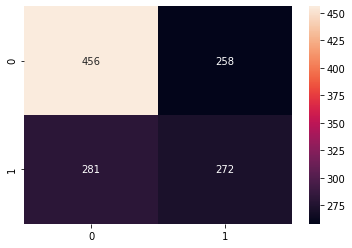

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = predictions_svc.select(['label']).collect()
y_pred = predictions_svc.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g')

Evaluating the Logistic Regression Model


              precision    recall  f1-score   support

         0.0       0.60      0.59      0.60       714
         1.0       0.49      0.50      0.49       553

    accuracy                           0.55      1267
   macro avg       0.55      0.55      0.55      1267
weighted avg       0.55      0.55      0.55      1267



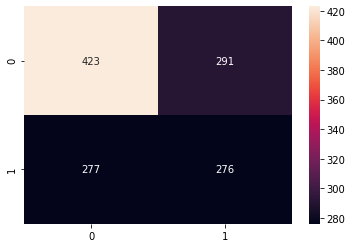

In [ ]:
y_true = predictions_lr.select(['label']).collect()
y_pred = predictions_lr.select(['prediction']).collect()

print(classification_report(y_true, y_pred))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g')

Code to extract the links provided by the user and store in a list

In [ ]:
from time import time
import requests
import webbrowser
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.request import HTTPError

from pyspark import SparkContext

#sc = SparkContext()

start_time = time()

url_list_path = '/content/gdrive/My Drive/links.csv'

urls_lines = sc.textFile(url_list_path)

def processRecord(url):
    if len(url) > 0:
        page = urlopen(url)
        soup = BeautifulSoup(page, features="lxml")
        rtnVal = soup.prettify()
    else:
        url = "NA"
        rtnVal = "NA"
    return [url, rtnVal]

temp = urls_lines.map(processRecord)

temp_rdd = temp.collect()

for elem in temp_rdd:
    print(elem)

print("Time taken: " + str(time() - start_time))


['https://www.nytimes.com/live/2021/08/25/world/afghanistan-taliban-kabul-biden-news', '<!DOCTYPE html>\n<html lang="en" xmlns:og="http://opengraphprotocol.org/schema/">\n <head>\n  <title data-rh="true">\n   Security Threats at Kabul Airport Prompt Multiple Warnings - The New York Times\n  </title>\n  <meta content="2021-08-25T08:50:58.000Z" data-rh="true" property="article:published_time"/>\n  <meta content="2021-08-29T16:56:06.461Z" data-rh="true" property="article:modified_time"/>\n  <meta content="en" data-rh="true" http-equiv="Content-Language"/>\n  <meta content="noarchive" data-rh="true" name="robots"/>\n  <meta content="100000007937745" data-rh="true" name="articleid"/>\n  <meta content="nyt://legacycollection/8fa389b5-b44c-5524-953a-8158ad43a490" data-rh="true" name="nyt_uri"/>\n  <meta content="pubp://event/7b6ac3abca1641c3baf713601b2496c9" data-rh="true" name="pubp_event_id"/>\n  <meta content="The U.S., U.K. and Australia warned of an unspecified threat outside the Kabul a

Extracting the article from the links

In [ ]:
	def findonNYT(name):
		urllist =[]
		page = requests.get("https://www.nytimes.com/search?endDate=20190708&query="+name+"%20news&sort=best&startDate=20180408")
		soup = BeautifulSoup(page.content,'html.parser')
		titles = soup.findAll("li",attrs={"class":"css-1l4w6pd"})
		titles_string = str(titles)
		
		soup1 = BeautifulSoup(titles_string,features ="lxml")
		for a in soup1.find_all('a', href=True):
			x = a['href']
			if x[0]=="/":
				x = "https://www.nytimes.com"+x
				striploc = x.find("?search")
				x = x[:striploc]
				urllist.append(x)
		return urllist
		

In [ ]:
list=findonNYT('Amazon')
print(list)

['https://www.nytimes.com/2019/06/11/technology/antitrust-hearing.html', 'https://www.nytimes.com/2019/06/10/technology/big-tech-antitrust-scrutiny.html', 'https://www.nytimes.com/2019/05/01/technology/personaltech/tech-is-changing-new-york-but-not-how-he-reports-on-the-city.html', 'https://www.nytimes.com/2019/02/08/business/media/jeff-bezos-ami-national-enquirer-fight.html', 'https://www.nytimes.com/2019/01/14/reader-center/alexa-smart-speakers-new-york-times.html', 'https://www.nytimes.com/2018/12/27/nyregion/amazon-queens-real-estate.html', 'https://www.nytimes.com/2018/12/23/business/media/worst-media-people-trump-fox-news-cbs-moonves.html', 'https://www.nytimes.com/2018/06/29/technology/amazon-world-domination.html', 'https://www.nytimes.com/2019/02/08/nyregion/amazon-hq.html', 'https://www.nytimes.com/2018/12/27/realestate/interest-in-court-square-condo-spikes-thanks-to-amazon.html']


In [ ]:
def extract_contentNYT(url):
		sentences =[] 
		page = requests.get(url)
		soup = BeautifulSoup(page.content, 'html.parser')
		titles = soup.findAll("p",attrs={"class":"css-axufdj evys1bk0"})
		print("\n\n article content")
		for item in titles:
			#print(item.text.encode().strip())
			print(item.get_text())
			sentences.append(item.get_text())
		return sentences

In [ ]:
text=extract_contentNYT('https://www.nytimes.com/2019/06/11/technology/antitrust-hearing.html')
column=["statement"]
data = [(line,) for line in text]
article = spark.createDataFrame(data=data,schema=column)
article.printSchema()
article.head(5)



 article content
WASHINGTON — A congressional investigation into the power of big tech companies began on Tuesday with bipartisan concern from lawmakers that the government’s lax oversight of the industry may be doing more harm than good.
In its first hearing about the power held by Google, Facebook, Amazon and Apple, lawmakers focused on the decline of the news industry. They said they were troubled that the online digital advertising market, which is dominated by Google and Facebook, had siphoned off too much revenue from news organizations.
“Concentration in the digital advertising market has pushed local journalism to the verge of extinction,” said Representative David Cicilline, a Democrat from Rhode Island.
The hearing was the start of the House Judiciary Committee’s inquiry into possible anticompetitive behavior by big tech companies, part of a rising wave of federal scrutiny of the industry.
The House committee plans several hearings, depositions and interviews with competito

[Row(statement='WASHINGTON — A congressional investigation into the power of big tech companies began on Tuesday with bipartisan concern from lawmakers that the government’s lax oversight of the industry may be doing more harm than good.'),
 Row(statement='In its first hearing about the power held by Google, Facebook, Amazon and Apple, lawmakers focused on the decline of the news industry. They said they were troubled that the online digital advertising market, which is dominated by Google and Facebook, had siphoned off too much revenue from news organizations.'),
 Row(statement='“Concentration in the digital advertising market has pushed local journalism to the verge of extinction,” said Representative David Cicilline, a Democrat from Rhode Island.'),
 Row(statement='The hearing was the start of the House Judiciary Committee’s inquiry into possible anticompetitive behavior by big tech companies, part of a rising wave of federal scrutiny of the industry.'),
 Row(statement='The House co

In [ ]:
article = tokenize(article)
article=remove_stopw(article)
article = count_vectorizer.transform(article)
article = indexerFit.transform(article)

Data Preprocessing on the article

In [ ]:
article.show(4)

+--------------------+--------------------+--------------------+--------------------+
|           statement|               words|            filtered|            features|
+--------------------+--------------------+--------------------+--------------------+
|WASHINGTON — A co...|[washington, a, c...|[washington, cong...|(12104,[29,173,25...|
|In its first hear...|[in, its, first, ...|[first, hearing, ...|(12104,[24,43,191...|
|“Concentration in...|[concentration, i...|[concentration, d...|(12104,[24,183,21...|
|The hearing was t...|[the, hearing, wa...|[hearing, start, ...|(12104,[25,64,173...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 4 rows



Running the model on the extracted article to generate a prediction

In [ ]:
predict = lrModel.transform(article)

In [ ]:
predict.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|           statement|               words|            filtered|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|WASHINGTON — A co...|[washington, a, c...|[washington, cong...|(12104,[29,173,25...|[-74.064347086702...|[6.82751643883003...|       1.0|
|In its first hear...|[in, its, first, ...|[first, hearing, ...|(12104,[24,43,191...|[305.214296869588...|           [1.0,0.0]|       0.0|
|“Concentration in...|[concentration, i...|[concentration, d...|(12104,[24,183,21...|[141.754425183607...|           [1.0,0.0]|       0.0|
|The hearing was t...|[the, hearing, wa...|[hearing, start, ...|(12104,[25,64,173...|[1261.40390717536...|           [1.0,0.0]|       0.0|
|The House committ...|[the,

In [ ]:
!pip install dask["complete"]
!pip install dask_ml["complete"]

Writing the processed dataset to a csv file

In [ ]:
#train.coalesce(1).write.csv("/content/gdrive/My Drive/traincsv",header=True) 

Loading the file contents to a pandas dataframe to be processed in dask

In [ ]:
from dask.distributed import Client, progress

client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client



/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35511 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:46205 Dashboard: http://127.0.0.1:35511/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


In [ ]:
train = pd.read_table('/content/gdrive/My Drive/train.tsv', names = ["id", "target_label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])
test=pd.read_table('/content/gdrive/My Drive/test.tsv', names = ["id", "target_label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])
valid=pd.read_table('/content/gdrive/My Drive/valid.tsv', names = ["id", "target_label", "statement", "subject", "speaker", "job", "state", "party",
                                            "barely-true", "false", "half-true", "mostly-true", "pants-fire", "venue"])


Data preprocessing for dask

In [ ]:
y_label_dict = {"pants-fire" : 0, "false" : 0, "barely-true" : 0, "half-true" : 1, "mostly-true" : 1, "true" : 1}
print(y_label_dict)
train['output'] = train['target_label'].apply(lambda x: y_label_dict[x])
valid['output'] = valid['target_label'].apply(lambda x: y_label_dict[x])
test['output'] = test['target_label'].apply(lambda x: y_label_dict[x])

{'pants-fire': 0, 'false': 0, 'barely-true': 0, 'half-true': 1, 'mostly-true': 1, 'true': 1}


Training data loaded for dask implementation

In [ ]:
train.head()

,id,target_label,statement,subject,speaker,job,state,party,barely-true,false,half-true,mostly-true,pants-fire,venue,output
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,1
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,1


In [ ]:
import dask.dataframe as dd

df = dd.from_pandas(pd.DataFrame({"text": train.statement, "target": train.output}),
                    npartitions=25)

df1 = dd.from_pandas(pd.DataFrame({"text": test.statement, "target": test.output}),
                    npartitions=25)
df

,text,target
npartitions=25,,
0,object,int64
410,...,...
...,...,...
9840,...,...
10239,...,...


Text Vectorization (Feature Extraction in Dask
)

In [ ]:
import dask_ml.feature_extraction.text

vect = dask_ml.feature_extraction.text.HashingVectorizer()
X = vect.fit_transform(df['text'])
X.blocks[0].compute()

<410x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 6672 stored elements in Compressed Sparse Row format>

In [ ]:
import numpy as np

y = df['target'].astype(int)
y1=df1['target'].astype(int)

In [ ]:
import numpy as np
import sklearn.linear_model
import sklearn.pipeline

import dask_ml.wrappers

Function of (Stochiastic Gradient Descent) solver- Logistic Regression formula is used (Best accuracy achieved by this model)

In [ ]:
sgd = sklearn.linear_model.SGDClassifier(
    tol=1e-3
)
clf = dask_ml.wrappers.Incremental(
    sgd, scoring='accuracy', assume_equal_chunks=True
)
pipe = sklearn.pipeline.make_pipeline(vect, clf)

Training the Model

In [ ]:
pipe.fit(df['text'], y,incremental__classes=[0, 1]);

Predicting on training Data

In [ ]:
predictions = pipe.predict(df['text'])
predictions

dask.array<_predict, shape=(nan,), dtype=int64, chunksize=(nan,), chunktype=numpy.ndarray>

Accuracy on Training data


In [ ]:
dask_ml.metrics.accuracy_score(y, predictions)

0.628515625

Predicting on Test data


In [ ]:
predictions = pipe.predict(df1['text'])
predictions

dask.array<_predict, shape=(nan,), dtype=int64, chunksize=(nan,), chunktype=numpy.ndarray>

Accuracy on test data


In [ ]:
dask_ml.metrics.accuracy_score(y1, predictions)

0.5627466456195738